## Define required constants and functions

In [38]:
# Imports
import numpy as np
import numpy.polynomial.polynomial as poly
import numpy.linalg as la
from numpy.polynomial import Polynomial as Poly

# Define constants
T0 = 298 # (K)
k = 200  # (W/mK)
k_f = 26.24e-03  # (W/mK)
tb = 2e-03  # (m)
t = 1e-03  # (m)
W = 50e-03  # (m)
L = 50e-03  # (m)
v = 1.48e-05  # (kg/ms) (https://en.wikipedia.org/wiki/Viscosity)
density = 1.177  # (kg/m^3)
Q = 30  # (W)
u = 1.846e-05
c_p = 1.0049e+03
V_f = 2


# Define functions
# Cross sectional area - [Checked] 
def A():
    return t * L
    #return (tb * W) + (N * t * (H - tb))


# Fin seperation - [Checked]
def b(N):
    #print(N)
    return (W - (N * t)) / (N - 1)


# Perimeter - [Checked]
def P():
    return (2 * L) + (2 * t)
    #return (2 * H) + W + (N * t) + (2 * (N - 1) * (H - tb)) + ((N-1) * b(N))


# Channel velocity - [Checked]
def V_ch(V_f, N):
    return V_f * (1 + (t / b(N)))


# Hydraulic diameter (This function is trivial, it used for clarity) - [Checked]
def D_h(N):
    #print(N)
    #print(b(N))
    return 2 * b(N)


# Channel Reynolds number - [Checked]
def c_rn(V_f, N):
    return (D_h(N) * V_ch(V_f, N)) / v


# Modified channel Reynolds number - [Checked]
def m_c_rn(V_f, N):
    return (b(N) * V_ch(V_f, N) / v) * (b(N) / L)


# Prandtl number - [Checked]
def Pr():
    #return 0.707  # This just return a hard coded value for now
    return (c_p * u) / k_f

# Nessult number - [Checked]
def n_n(V_f, N, H):
    first_term = (m_c_rn(V_f, N) * Pr() / 2) ** -3
    second_term = (0.664 * np.sqrt(m_c_rn(V_f, N)) * (Pr() ** (1/3)) * np.sqrt(1 + (3.65 / np.sqrt(m_c_rn(V_f, N))))) ** -3
    return (first_term + second_term) ** (-1/3)


# Heat transfer coefficient - [Checked]
def h(N, H, V_f):
    return (n_n(V_f, N, H) * k_f) / b(N)


# Fin parameter - [Checked]
def m(N, H, V_f):
    return np.sqrt(h(N, H, V_f) * P() / (k * A()))


# Resistance of each fin - [Checked]
def R_fin(N, H, V_f):
#     print("h: ", h(N, H, V_f))
#     print("P: ", P())
#     print("k: ", k)
#     print("A: ", A())
#     print("m: ", m(N, H, V_f))
#     print("H: ", H, "\n")
    return 1 / (np.sqrt(h(N, H, V_f) * P() * k * A()) * np.tanh(m(N, H, V_f) * H))


# Resistance of the heat sink - [Checked]
def R_sink(N, H, V_f):
    first_term = 1 / ((N / R_fin(N, H, V_f)) + (h(N, H, V_f) * (N - 1) * b(N) * L))
    second_term = tb / (k * L * W)
    return first_term + second_term

# Sigma - [Checked]
def sigma(N):
    return 1 - ((N * t) / W)


# Compression loss coefficient - [Checked]
def K_c(N):
    return 0.42 * (1 - (sigma(N) ** 2))


# Expansion loss coefficient  - [Checked]
def K_e(N):
    return (1 - (sigma(N) ** 2)) ** 2


# Dimensionless fin length - [Checked]
def L_star(V_f, N):
    #print("Calculating L_star")
    #print("c_rn: {}".format(c_rn(V_f, N)))
    #print("D_h: {}".format(D_h(N)))
    return L / (D_h(N) * c_rn(V_f, N))


# Friction factor - [Checked]
def ff(N, H, V_f):
    first_term = 32.527 * (b(N) / H)
    second_term = 46.721 * ((b(N) / H) ** 2)
    third_term = 40.829 * ((b(N) / H) ** 3)
    fourth_term = 22.954 * ((b(N) / H) ** 4)
    fifth_term = 6.089 * ((b(N) / H) ** 5)
    numerator = 24 - first_term + second_term - third_term + fourth_term - fifth_term
    return numerator / c_rn(V_f, N)


# Apparent friction factor - [Checked]
def f_app(N, H, V_f):
    #print("L_star: {}".format(L_star(V_f, N)))
    #print("f: {}".format(f(N, H, V_f)))
    return np.sqrt(((3.44 / np.sqrt(L_star(V_f, N))) ** 2) + (((ff(N, H, V_f) * c_rn(V_f, N))) ** 2)) / c_rn(V_f, N)


# Total drag force - [Checked]
def F_d(N, H, V_f):
    dynamic_pressure = (1 / 2) * density * (V_ch(V_f, N) ** 2)
    return dynamic_pressure * (f_app(N, H, V_f) * N * ((2 * H * L) + (b(N) * L))) + (K_c(N) * H * W) + (K_e(N) * H * W)


# Pressure drop - [Checked]
def pd(N, H, V_f):
    return F_d(N, H, V_f) / (H * W)



# Fan curve data
air_flow = np.array([  # (m^3/minute)
    0.000986,
    0.010927,
    0.019692, 
    0.026641,
    0.033804, 
    0.04086, 
    0.045887, 
    0.050378, 
    0.056473, 
    0.059575, 
    0.063212, 
    0.068988, 
    0.074659, 
    0.079047, 
    0.087290, 
    0.092428, 
    0.101310, 
    0.112542, 
    0.121313, 
    0.129334, 
    0.139600, 
    0.148688, 
    0.158951, 
    0.167931, 
    0.177445, 
    0.188669, 
    0.197220, 
    0.205665, 
    0.215929, 
    0.224376, 
    0.232290, 
    0.241380, 
    0.249081, 
    0.255499, 
    0.262240, 
    0.266948, 
    0.271015, 
    0.273263,
])

static_pressure = np.array([  # mm-H20
    29.7972,
    29.3063,
    28.8032,
    28.3493,
    27.8342,
    27.2824,
    26.7185,
    26.2771,
    25.6886,
    25.2107,
    24.7450,
    23.9483,
    22.9680,
    22.1348,
    20.1990,
    19.0473,
    17.3931,
    15.8366,
    14.6478,
    13.7897,
    12.7598,
    11.9506,
    11.2147,
    10.6014,
    10.0738,
    9.4970,
    9.0552,
    8.4664,
    7.6693,
    6.9336,
    6.1000,
    5.1316,
    4.1510,
    3.2319,
    2.1045,
    1.2345,
    0.4380,
    0.0000,
])

# Use numpy to fit a curve to the fan data 
coefs = poly.polyfit(air_flow, static_pressure, 5)
ffit = poly.polyval(air_flow, coefs)
p = Poly.fit(air_flow, static_pressure, deg=10)

# Given a value for the pressure drop get the positive 
# real root of the function when shifted down by the value
def V_f_fan_curve(N, H, V_f):
    roots = (p - pd(N, H, V_f)).roots()
    positive_real_roots = []
    for root in roots:
        if not root.imag and root.real >= 0:
            positive_real_roots.append(root.real)
            print(root.real)
            return root.real / (45e-03 * 15e-03 * 60)


# Entropy generation rate - [Checked]
def S_gen_rate(N, H, V_f):
    first_term = ((Q ** 2) * R_sink(N, H, V_f)) / (T0 ** 2)
    second_term = F_d(N, H, V_f) * (V_f / T0)
    return first_term + second_term



## Plot the entropy generation rate as a function of N

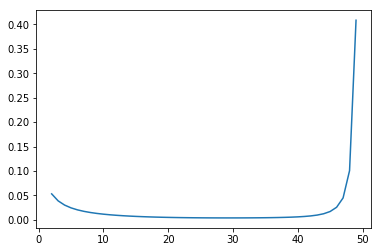

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt

H = 25e-3
V_f = 2

values = []
for N in range(2, 50):
    values.append(S_gen_rate(N, H, V_f))

N = range(2, 50)
plt.plot(N, values)

# values = []
# for N in range(2, 50):
#     values.append(R_sink(N, H, V_f))
    
# N = range(2, 50)
# plt.plot(N, values)

# values = []
# for N in range(2, 50):
#     values.append(R_fin(N, H, V_f))
    
# N = range(2, 50)
# plt.plot(N, values)

## Solve for N (with fan curve)

In [81]:
# Define the equation to be minimised
def f(x):
    return (Q ** 2) * R_sink(x, H, V_f) / (T0 ** 2) + (F_d(x, H, V_f) * V_f / T0)

# Define the first and second order derivatives of f(x)
delta = 1e-05  # Define the tolerance setting
def dfdx(x):
    return (f(x + delta) - f(x)) / delta


def dffdxx(x):
    return (f(x + delta) - (2 * f(x)) + f(x - delta)) / (delta ** 2)

# Define constants and initial values
x = 10
H = 60e-03
V_f = 2
e = 1e-05
i = 0
# Run Newton's method until the derivative of the function is within 1e-05 of zero
while np.absolute(dfdx(x)) > e:
    V_f = 1.119 + (6.758e-03 * x) - (1.345e-03 * x ** 2) + (1.485e-05 * x ** 3)
    x -= dfdx(x) / dffdxx(x)
    
    # Increment the counter
    i += 1
    
    # Output each iterations results
    print("Iteration: {} | N: {}, V_f: {}, \u03B8: {}, S: {}".format(i, format(x, '.2f'), format(V_f, '.2f'), format((Q * R_sink(x, H, V_f)), '.2f'), format(f(x), '.5f')))
    
# Output the final result
print("\nFound minimum with {} fins, in {} iterations.".format(int(round(x)), i))

Iteration: 1 | N: 14.70, V_f: 1.07, θ: 15.19, S: 0.00516
Iteration: 2 | N: 19.91, V_f: 0.97, θ: 11.96, S: 0.00410
Iteration: 3 | N: 24.52, V_f: 0.84, θ: 11.89, S: 0.00409
Iteration: 4 | N: 28.80, V_f: 0.69, θ: 13.25, S: 0.00458
Iteration: 5 | N: 31.59, V_f: 0.55, θ: 15.92, S: 0.00548

Found minimum with 32 fins, in 5 iterations.


## Solve for N, H, and V_f 

In [83]:
# Define the function to be optimised
def f(x, y, z):
    #return ((x + 5) ** 2) + ((y + 2) ** 2) - 10
    return (Q ** 2) * R_sink(x, y, z) / (T0 ** 2) + (F_d(x, y, z) * z / T0)

# Define the first and second partial derivatives wrt N (x), H (y), and V_f (z)
delta = 1e-05


def dfdx(x, y, z):
    return (f(x + delta, y, z) - f(x, y, z)) / delta


def dfdy(x, y, z):
    return (f(x, y + delta, z) - f(x, y, z)) / delta


def dfdz(x, y, z):
    return (f(x, y, z + delta) - f(x, y, z)) / delta


def ddfdxx(x, y, z):
    return (f(x + delta, y, z) - (2 * f(x, y, z)) + f(x - delta, y, z)) / (delta ** 2)


def ddfdyy(x, y, z):
    return (f(x, y + delta, z) - (2 * f(x, y, z)) + f(x, y - delta, z)) / (delta ** 2)


def ddfdzz(x, y, z):
    return (f(x, y, z + delta) - (2 * f(x, y, z)) + f(x, y, z - delta)) / (delta ** 2)


def ddfdxy(x, y, z):
    return (f(x + delta, y + delta, z) - f(x + delta, y - delta, z) - f(x - delta, y + delta, z) + f(x - delta, y - delta, z)) / (4 * delta ** 2)


def ddfdyz(x, y, z):
    return (f(x, y + delta, z+ delta) - f(x, y + delta, z - delta) - f(x, y - delta, z + delta) + f(x, y - delta, z - delta)) / (4 * delta ** 2)


def ddfdxz(x, y, z):
    return (f(x + delta, y, z+ delta) - f(x + delta, y, z - delta) - f(x - delta, y, z + delta) + f(x - delta, y, z - delta)) / (4 * delta ** 2)

# Define the initial feature vector
x_vector = np.matrix('25 ; 25.0e-03 ; 2')
e = 1e-10
i = 0
while np.absolute(dfdx(x_vector[0,0], x_vector[1,0], x_vector[2,0])) > e:
    # Get the individual values from the feature vector
    x = x_vector[0,0]
    y = x_vector[1,0]
    z = x_vector[2,0]
    
    # Define the Hessian matrix
    H_matrix_param = [ddfdxx(x, y, z)], [ddfdxy(x, y, z)], [ddfdxz(x, y, z)], [ddfdxy(x, y, z)], [ddfdyy(x, y, z)], [ddfdyz(x, y, z)], [ddfdxz(x, y, z)], [ddfdyz(x, y, z)], [ddfdzz(x, y, z)]
    H_matrix = np.matrix(H_matrix_param).reshape(3, 3)
    
    # Define the gradient vector of the function
    gradient_vector_param = [dfdx(x, y, z)], [dfdy(x, y, z)], [dfdz(x, y, z)]
    gradient_vector = np.matrix(gradient_vector_param)
    
    # Carry out Newton's method
    d_k = np.dot(la.inv(H_matrix), gradient_vector)
    if d_k[0,0] and d_k[1,0] and d_k[2,0]:
        x_vector -= d_k
    else:
        # If Newton's method returns a vector of magnitude zero then stop
        break

    # Increment the count variable
    i += 1
    # Print the results of the current iteration
    print("Iteration: {} | N: {}, H: {}mm, V_f: {}m/s, \u03B8: {} degrees".format(i, format(x_vector[0,0], '.2f'), format(y * 1000, '.2f'), format(x_vector[2,0], '.2f'), format((Q * R_sink(x_vector[0,0], x_vector[1,0], V_f)), '.2f')))
    
if np.absolute(dfdx(x_vector[0,0], x_vector[1,0], x_vector[2,0])) < e:
    # If the method completes successfully then print thr results
    print("\nFound minimum with {} fins, each {}mm tall, with free stream velocity {}m/s in {} iterations.".format(int(round(x)), int(round(1000 * x_vector[1,0])), format(z, '.2f'), i))
else:
    # If the method does not reduce the gradient of the fucntion sufficiently then indicate it has failed
    print("Failed after {} iterations.".format(i))

Iteration: 1 | N: 27.19, H: 25.00mm, V_f: 2.41m/s, θ: 26.71 degrees
Iteration: 2 | N: 25.55, H: 32.76mm, V_f: 2.24m/s, θ: 20.11 degrees
Iteration: 3 | N: 24.99, H: 45.82mm, V_f: 1.98m/s, θ: 16.23 degrees
Iteration: 4 | N: 24.87, H: 60.93mm, V_f: 1.81m/s, θ: 14.22 degrees
Iteration: 5 | N: 24.84, H: 74.52mm, V_f: 1.73m/s, θ: 13.35 degrees
Iteration: 6 | N: 24.83, H: 83.21mm, V_f: 1.71m/s, θ: 13.12 degrees
Iteration: 7 | N: 24.83, H: 85.98mm, V_f: 1.70m/s, θ: 13.10 degrees
Iteration: 8 | N: 24.83, H: 86.21mm, V_f: 1.70m/s, θ: 13.10 degrees

Found minimum with 25 fins, each 86mm tall, with free stream velocity 1.70m/s in 8 iterations.
